In [1]:
import pandas as pd
import numpy as np

### Load Dataset

In [2]:
sales = pd.read_csv("Dataset/Auto_Sales_data.csv")
sales.head()

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,DAYS_SINCE_LASTORDER,STATUS,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,CITY,POSTALCODE,COUNTRY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,24/02/2018,828,Shipped,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NYC,10022,USA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,07/05/2018,757,Shipped,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Reims,51100,France,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,01/07/2018,703,Shipped,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Paris,75508,France,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,25/08/2018,649,Shipped,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Pasadena,90003,USA,Young,Julie,Medium
4,10168,36,96.66,1,3479.76,28/10/2018,586,Shipped,Motorcycles,95,S10_1678,Technics Stores Inc.,6505556809,9408 Furth Circle,Burlingame,94217,USA,Hirano,Juri,Medium


### Data Cleaning

In [3]:
sales.size

54940

In [4]:
sales = sales.dropna()

In [5]:
sales.size

54940

Data is already clean

### Outlier Detection

In [6]:
from scipy import stats

z_scores = stats.zscore(sales[['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'MSRP']])
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).any(axis=1)
for i in range(0, len(outliers)):
    if outliers[i] == True:
        print(sales.iloc[i])
        print("----------------------------------")

ORDERNUMBER                             10417
QUANTITYORDERED                            66
PRICEEACH                              113.88
ORDERLINENUMBER                             2
SALES                                 7516.08
ORDERDATE                          13/05/2020
DAYS_SINCE_LASTORDER                       42
STATUS                               Disputed
PRODUCTLINE                       Motorcycles
MSRP                                       95
PRODUCTCODE                          S10_1678
CUSTOMERNAME            Euro Shopping Channel
PHONE                          (91) 555 94 44
ADDRESSLINE1               C/ Moralzarzal, 86
CITY                                   Madrid
POSTALCODE                              28034
COUNTRY                                 Spain
CONTACTLASTNAME                        Freyre
CONTACTFIRSTNAME                        Diego
DEALSIZE                                Large
Name: 23, dtype: object
----------------------------------
ORDERNUMBER          

The outliers can't be removed as we can see it is legit data.

### Data Visualisation

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

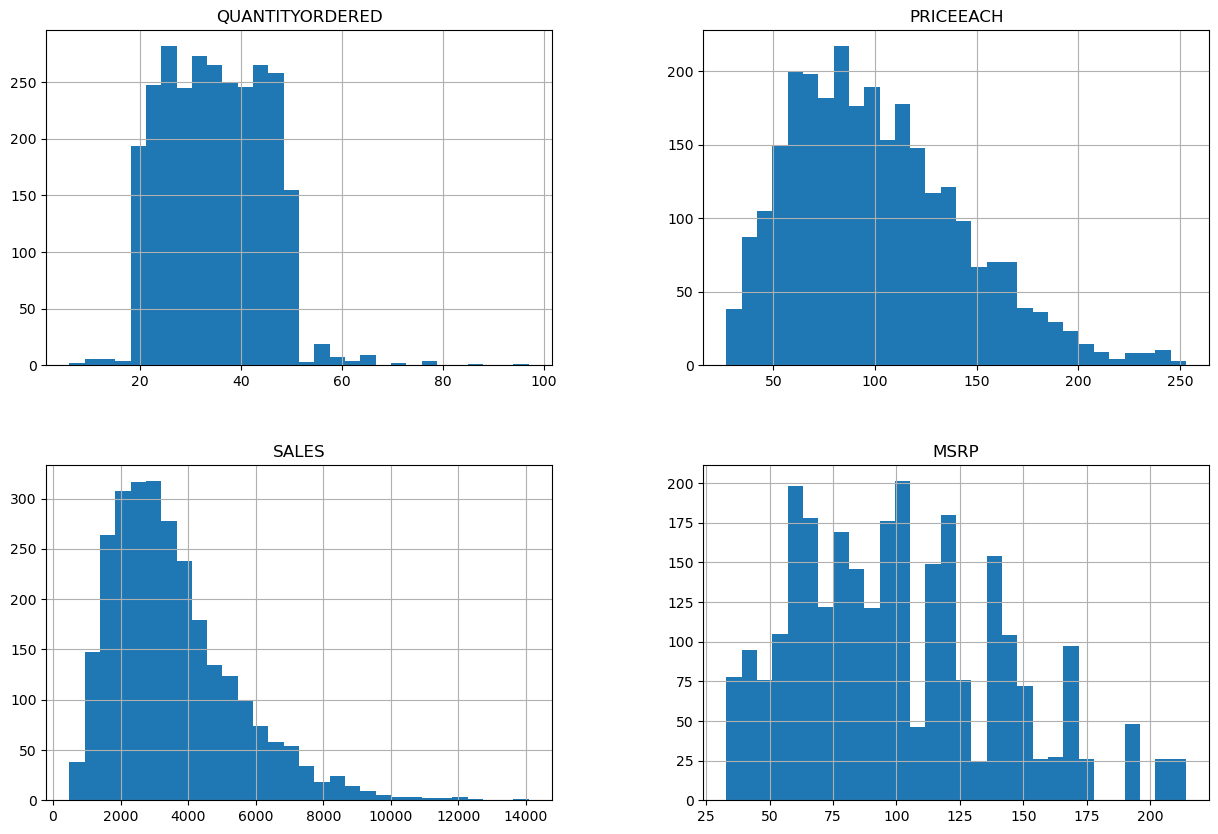

In [8]:
sales[['QUANTITYORDERED', 'PRICEEACH', 'SALES', 'MSRP']].hist(bins=30, figsize=(15, 10))
plt.show()

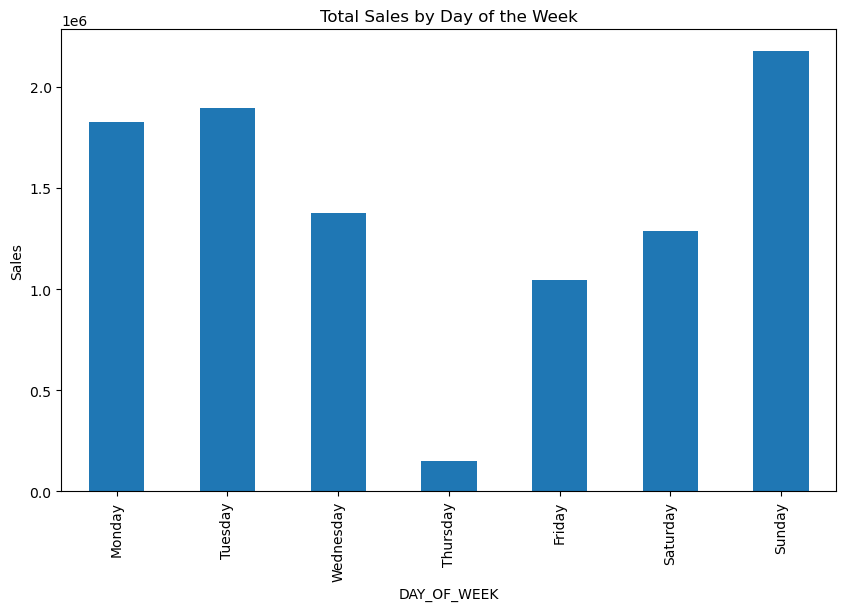

In [9]:
# Sales by day of week
sales['ORDERDATE'] = pd.to_datetime(sales['ORDERDATE'], dayfirst=True)
sales.set_index('ORDERDATE', inplace=True)
sales['DAY_OF_WEEK'] = sales.index.day_name()
sales_by_day = sales.groupby('DAY_OF_WEEK')['SALES'].sum()
sales_by_day = sales_by_day.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
sales_by_day.plot(kind='bar', figsize=(10, 6))
plt.title('Total Sales by Day of the Week')
plt.ylabel('Sales')
plt.show()

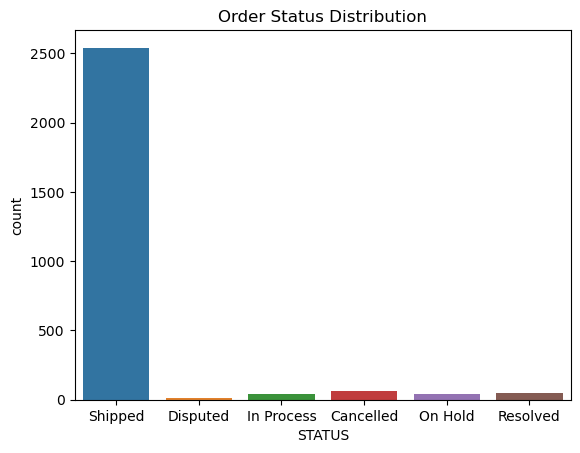

In [10]:
# order status
sns.countplot(x='STATUS', data=sales)
plt.title('Order Status Distribution')
plt.show()

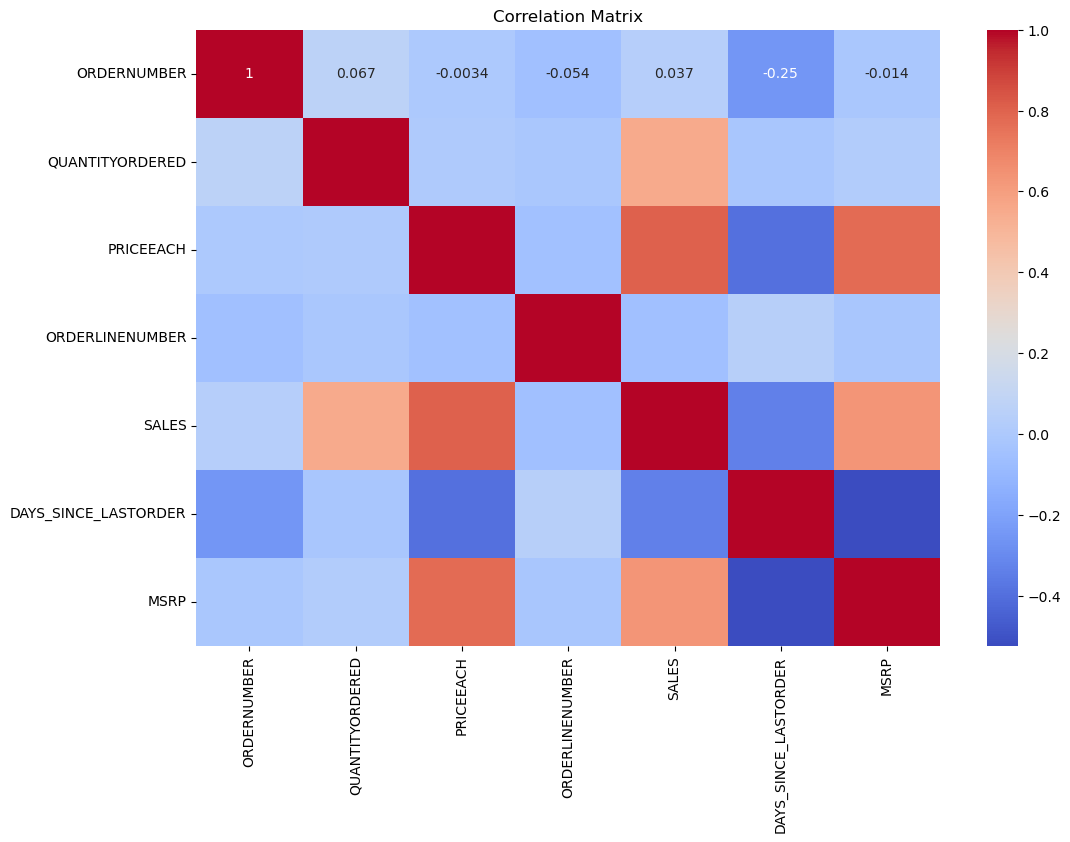

In [11]:
# Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(sales.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

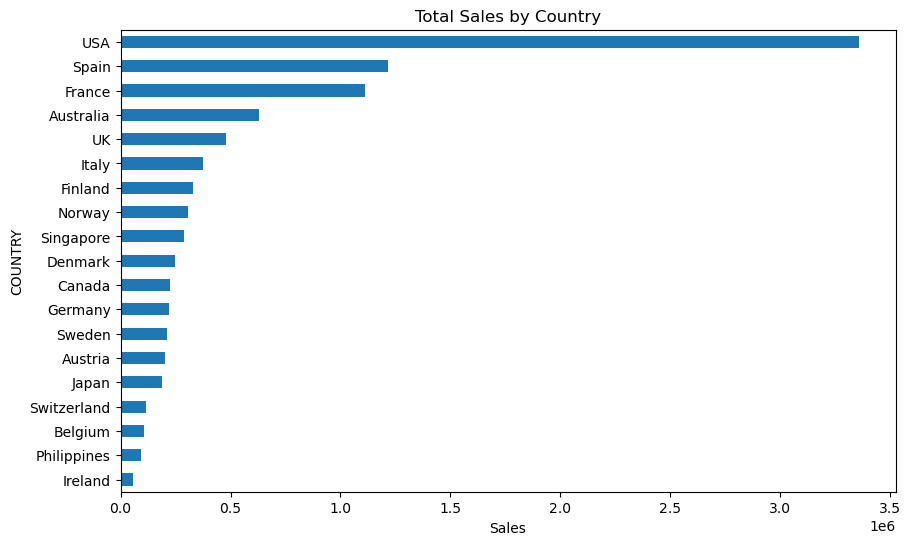

In [12]:
# Sales by Country
sales_by_country = sales.groupby('COUNTRY')['SALES'].sum().sort_values()
sales_by_country.plot(kind='barh', figsize=(10, 6))
plt.title('Total Sales by Country')
plt.xlabel('Sales')
plt.show()

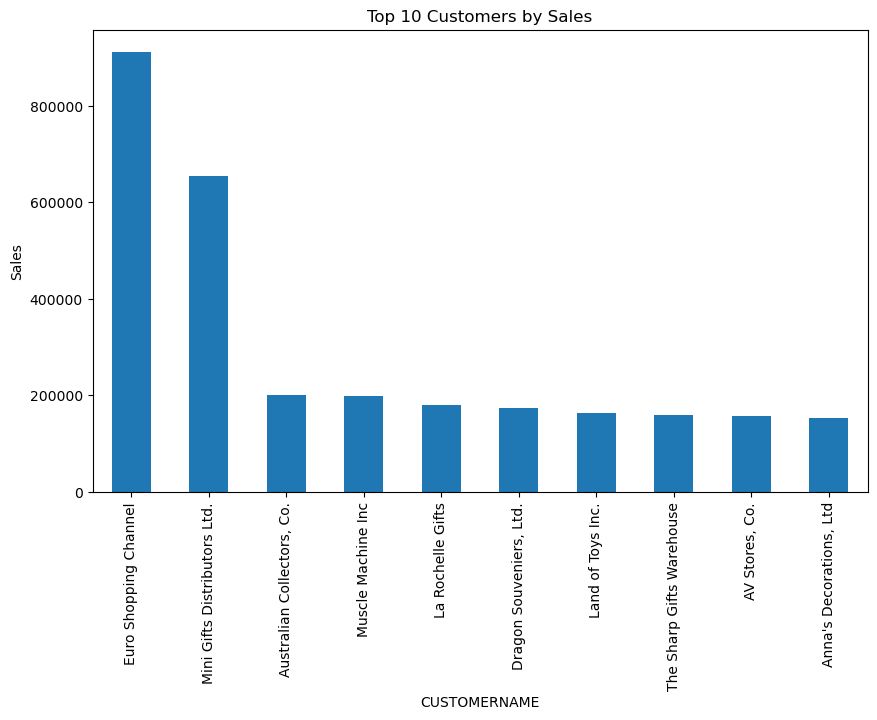

In [13]:
# Top customers
top_customers = sales.groupby('CUSTOMERNAME')['SALES'].sum().sort_values(ascending=False).head(10)
top_customers.plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Customers by Sales')
plt.ylabel('Sales')
plt.show()

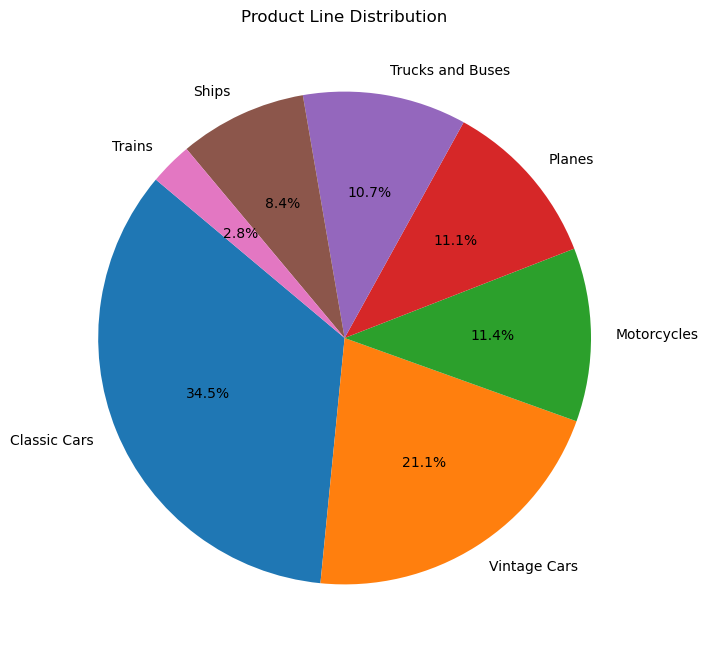

In [14]:
product_line_counts = sales['PRODUCTLINE'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(product_line_counts, labels=product_line_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Product Line Distribution')
plt.show()

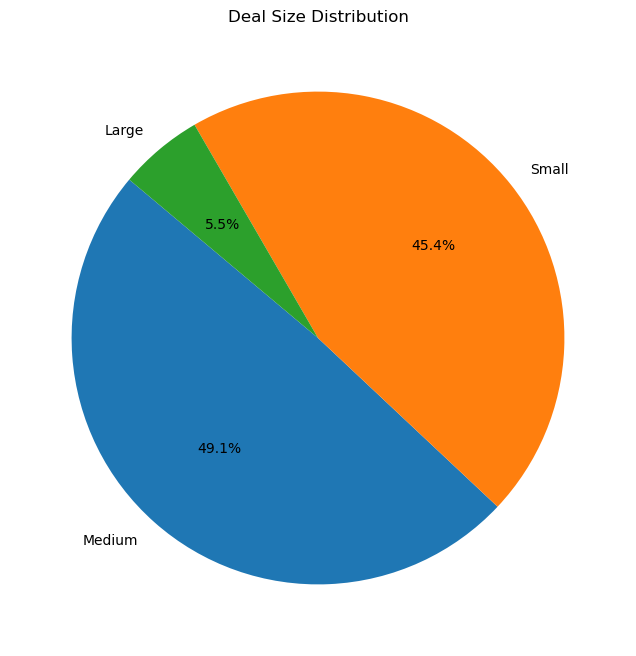

In [15]:
# Deal Size Distribution
deal_size_counts = sales['DEALSIZE'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(deal_size_counts, labels=deal_size_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Deal Size Distribution')
plt.show()

### Model Training

In [16]:
# Further Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [17]:
sales = pd.read_csv("Dataset/Auto_Sales_data.csv")
sales['ORDERDATE'] = pd.to_datetime(sales['ORDERDATE'], dayfirst=True)
sales['YEAR'] = sales['ORDERDATE'].dt.year
sales['MONTH'] = sales['ORDERDATE'].dt.month
sales['DAY_OF_WEEK'] = sales['ORDERDATE'].dt.dayofweek

In [18]:
# Removing unneeded columns
sales.drop(['ORDERNUMBER', 'ORDERDATE', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE', 'ADDRESSLINE1', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME'], axis=1, inplace=True)

In [19]:
# Features and targets
X = sales.drop('SALES', axis=1)
y = sales['SALES']

In [20]:
# categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [21]:
# Preprocess
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ]
)

In [22]:
# Train-test Set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
# Training
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [25]:
# models dictionary
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(random_state=42)
}

In [26]:
# Train
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    pipeline.fit(X_train, y_train)
    y_hat = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    r2 = r2_score(y_test, y_hat)
    results[model_name] = {'MSE': mse, 'R2': r2}

# Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results).T

In [27]:
results_df

,MSE,R2
Linear Regression,1.405091e+05,0.953906
Decision Tree,5.485302e+04,0.982006
Random Forest,1.846747e+04,0.993942
Gradient Boosting,2.452064e+04,0.991956
Support Vector Regressor,2.843587e+06,0.067169
K-Neighbors Regressor,4.495588e+05,0.852523
XGBoost,1.126809e+04,0.996304


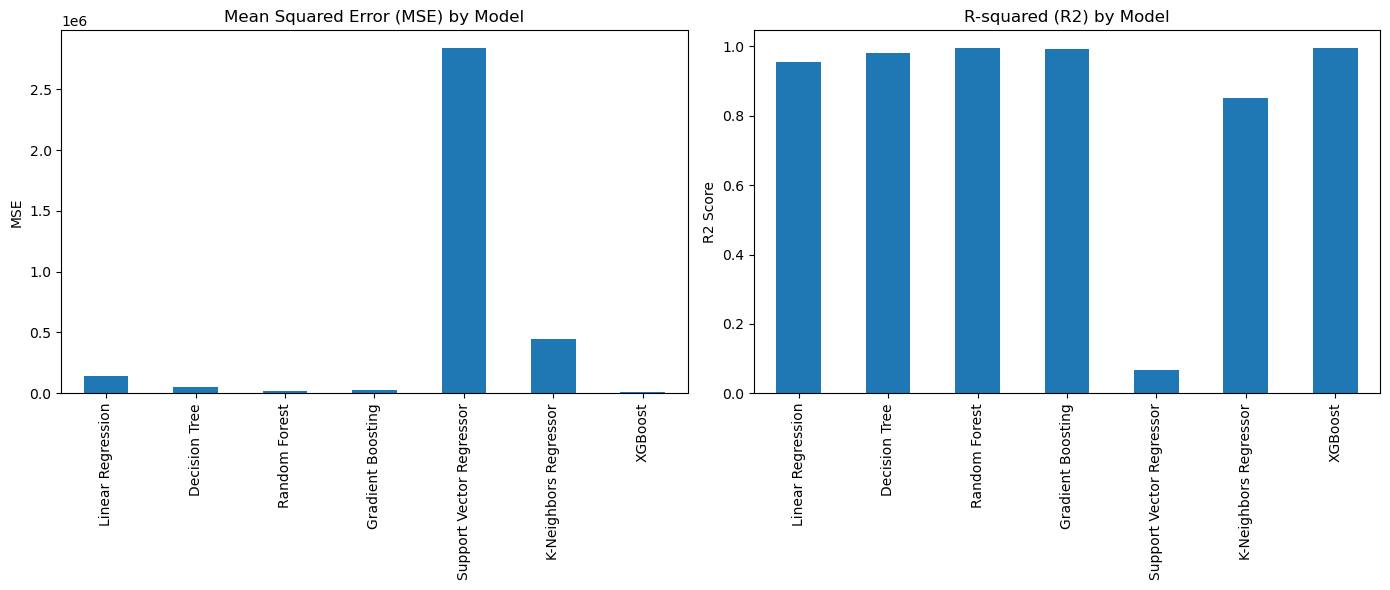

In [28]:
# Plotting
plt.figure(figsize=(14, 6))

# MSE
plt.subplot(1, 2, 1)
results_df['MSE'].plot(kind='bar')
plt.title('Mean Squared Error (MSE) by Model')
plt.ylabel('MSE')

# R2
plt.subplot(1, 2, 2)
results_df['R2'].plot(kind='bar')
plt.title('R-squared (R2) by Model')
plt.ylabel('R2 Score')

plt.tight_layout()
plt.show()

Overall, XGBoost performs best whereas SVR performs worst.